# import 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/MLMA/project/Code Isolated Data')

In [3]:
%load_ext autoreload
%autoreload 2
from preprocess import *

In [4]:
import numpy as np
import os
import math
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data as Data

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim.lr_scheduler as lr_scheduler

File name:  
EOG_00x_xx_xxx.csv:   
 00x: participant's ID  
 xx:  index of the recording time  
 xxx: index of the corresponding eye movements  
      - e.g., xxx is the index of a stroke  

In [5]:
result_path = '/content/drive/MyDrive/Colab Notebooks/MLMA/project/Code Isolated Data/Result'

# Prepocessing

In [ ]:
ID = 1 #(1,2,3,4,5,6)
r_time = 1 #(1,2,3,4,5,6,7,8,9,10)
R_time_str = '0' + str(r_time) if r_time < 10 else str(r_time)
stroke_idx = 1 #(1,2,3,4,5,6,7,8,9,10,11,12)
Stroke_idx_str = '0' + str(stroke_idx) if r_time < 10 else str(stroke_idx)

path = '/content/drive/MyDrive/Colab Notebooks/MLMA/project/Data/isolated/00' \
    + str(ID) + '/isolated_strokes/EOG_00' + str(ID) + '_' + R_time_str + '_0' + Stroke_idx_str + '.csv'

data_ = pd.read_csv(path, header=None).to_numpy()
data_p = preprocess(data_)
print(data_.shape)
print(data_p.shape)

(1250, 2)
(100, 2)


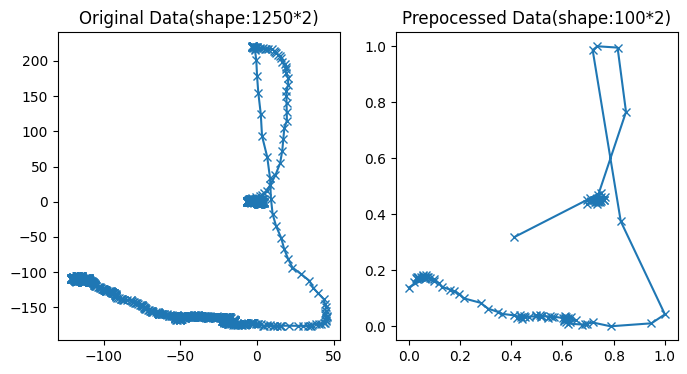

In [ ]:
plt.figure(1, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(data_[:, 0], data_[:, 1], '-x')
plt.title('Original Data(shape:1250*2)')
plt.subplot(1, 2, 2)
plt.plot(data_p[:, 0], data_p[:, 1], '-x')
plt.title('Prepocessed Data(shape:100*2)')
plt.show()

# Data Loader

In [6]:
class MyDataset(Dataset):
    def __init__(self, ID_list, R_time_list, root_dir='/content/drive/MyDrive/Colab Notebooks/MLMA/project/Data/isolated/00'):
        self.data = np.zeros((0, 100, 2))
        self.label = np.zeros((0,))
        for id_idx in range(len(ID_list)):
            ID = ID_list[id_idx]
            for i in range(len(R_time_list)):
                for stroke_idx in range(1, 13):
                    r_time = R_time_list[i]
                    R_time_str = '0' + str(r_time) if r_time < 10 else str(r_time)
                    Stroke_idx_str = '0' + str(stroke_idx) if stroke_idx < 10 else str(stroke_idx)
                    path = root_dir + str(ID) + '/isolated_strokes/EOG_00' + str(ID) + '_' + R_time_str + '_0' + Stroke_idx_str + '.csv'
                    if os.path.exists(path):
                        data_ = pd.read_csv(path, header=None).to_numpy()
                        data_ = preprocess(data_)
                        self.data = np.append(self.data, data_.reshape((1, 100, 2)), axis=0)
                        self.label = np.append(self.label, np.ones((1,))*(int(stroke_idx-1)), axis=0)
                
        self.data = torch.from_numpy(self.data)
        self.label = torch.from_numpy(self.label) 
        # print(self.data.shape, self.label.shape)
        
    def __getitem__(self, index):
        return self.data[index].float(), self.label[index].type(torch.LongTensor)
    
    def __len__(self):
        return self.data.shape[0]

# Model

In [ ]:
class My_lstm(nn.Module):
   def __init__(self, hidden_size, num_layers):
       super(My_lstm, self).__init__()
       self.lstm = nn.LSTM(input_size=2,
                           hidden_size=hidden_size,
                           num_layers=num_layers,
                           batch_first=True,
                           bidirectional=False,
                           dropout=0.5)
       for name, param in self.lstm.named_parameters():
           if name.startswith("weight"):
               nn.init.xavier_normal_(param)
           else:
               nn.init.zeros_(param)
       self.flatten = nn.Flatten()
       self.fc1 = nn.Linear(hidden_size*100, 50)
       self.relu1 = nn.LeakyReLU()
       self.fc2 = nn.Linear(50, 12)


      
   def forward(self, x):
       x, (_, _) = self.lstm(x)
       x = self.flatten(x)
       x = self.relu1(self.fc1(x))
       x = self.fc2(x)
       return x

In [ ]:
class My_gru(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super(My_gru, self).__init__()
        self.gru = nn.GRU(input_size=2,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=False,
                            dropout=0.5)
        for name, param in self.gru.named_parameters():
            if name.startswith("weight"):
                nn.init.xavier_normal_(param)
            else:
                nn.init.zeros_(param)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(hidden_size*100, 50)
        self.relu1 = nn.LeakyReLU()
        self.fc2 = nn.Linear(50, 12)
        
    def forward(self, x):
        x, _ = self.gru(x)
        x = self.flatten(x)
        x = self.relu1(self.fc1(x))
        x = self.fc2(x)
        return x

# Functions

In [ ]:
def Train_model(model,epochs,optmizer,criterion, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    train_loss = []
    x = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
        optmizer.zero_grad()  
        output = model(data)
        # print(type(output), type(label))
        loss = criterion(output, label)
        loss.backward()
        optmizer.step() 
        train_loss.append(loss.item()) 
        #if(batch_idx+1)%3 == 0:
            #print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.\
                #format(epochs, batch_idx * len(data), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
    return np.mean(train_loss), model

In [ ]:
def test(model,epochs,criterion, dataloader, T_T='Test'):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_loss = 0
    c = 0
    y_pred = np.zeros((0,))
    y_true = np.zeros((0, ))
    with torch.no_grad():
        for data, label in dataloader:
            data = data.to(device)
            label = label.to(device)
            output = model(data)
            test_loss += criterion(output, label).item()
            y_pred = np.append(y_pred, output.cpu().argmax(dim=-1), axis=0)
            y_true = np.append(y_true, np.squeeze(label.cpu()), axis=0)
            c += 1
    test_loss /= c
    #if epochs%10 == 0:
        #print('EPOCH:{}    {} set: Average loss: {:.4f}'.format(epochs, T_T, test_loss))
  
    return test_loss, accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='micro', zero_division=0), \
    f1_score(y_true, y_pred, average='macro', zero_division=0), precision_score(y_true, y_pred, average='micro', zero_division=0), \
    precision_score(y_true, y_pred, average='macro', zero_division=0), recall_score(y_true, y_pred, average='micro', zero_division=0), \
    recall_score(y_true, y_pred, average='macro', zero_division=0)

In [ ]:
def main_function(total_epoch=100, dataloader_list=None, model_para=None, model_save=False, model_name=None, cross_val=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    if model_para == 1:
      pass
    else:
      if model_para['LSTM'] == True:
          model = My_lstm(model_para['hidden_size'], model_para['num_layers']).to(device)
      else:
          model = My_gru(model_para['hidden_size'], model_para['num_layers']).to(device)
        
    optmizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-2)  
    # optmizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-2) 
    scheduler = lr_scheduler.StepLR(optmizer, step_size=300, gamma=0.5, verbose=False) 
    criterion = nn.CrossEntropyLoss().to(device)  
    
    train_loss = np.zeros((total_epoch))
    score = np.zeros((len(dataloader_list), 8, total_epoch)) # loss, accuracy, f1 score*2, precision*2, recall*2
    
    for i in tqdm(range(total_epoch)):
        train_loss[i], model = Train_model(model, i, optmizer, criterion, dataloader_list[0])
        scheduler.step()
        for j in range(len(dataloader_list)):
            if j == 0:
                T_T = 'Train'
            elif j == 1:
                T_T = 'Validation'
            else:
                T_T = 'Test'
            score[j, :, i] = test(model, i, criterion, dataloader_list[j], T_T=T_T)
        #if np.argmin(score[1, 0, :(i+1)]) == i:
            #if model_save:
                #torch.save(model.state_dict(), model_name)     
    #if model_save: 
        #np.savez(model_name[:-4], train_loss=train_loss, score=score)
    if model_save:
      torch.save(model.state_dict(), model_name)
    if cross_val:
        epoch_best = np.argmin(score[1, 0, :])
        return score[:, :, epoch_best]
    else:
        return train_loss, score

# Training

### num layer = 1

In [ ]:
hidden_size_list = [2, 4]
num_layers_list = [1]
l_g = [True, False]
BATCH_SIZE = 8

In [ ]:
from tqdm import tqdm

In [ ]:
score = np.zeros((6, 5, len(hidden_size_list), len(num_layers_list), len(l_g), 3, 8))
# participants, folds, hidden size, layers number, LSTM or GRU, Train/Val/Test, 8score
for ID in range(1, 7):
    for folder_idx in range(1, 11, 2):
        R_time_test = [folder_idx+1, folder_idx+2 if folder_idx+2 <= 10 else folder_idx+2-10]
        test_dataset = MyDataset([ID], R_time_test)
        test_loader = Data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        R_time_val = [folder_idx]
        val_dataset = MyDataset([ID], R_time_val)
        val_loader = Data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        R_time_train = []
        for i in range(1, 11):
            if i not in R_time_test and i not in R_time_val:
                R_time_train.append(i)
        train_dataset = MyDataset([ID], R_time_train)
        train_loader = Data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        
        for hsize_idx in range(len(hidden_size_list)):
            for l_idx in range(len(num_layers_list)):
                for l_g_idx in range(len(l_g)):
                    model_param = {'LSTM': l_g[l_g_idx], 'hidden_size':hidden_size_list[hsize_idx], 'num_layers':num_layers_list[l_idx]}
                    score[ID-1, int(np.floor(folder_idx/2)), hsize_idx, l_idx, l_g_idx] = \
                        main_function(total_epoch=500, dataloader_list=[train_loader, val_loader, test_loader], \
                            model_para=model_param, model_save=False, cross_val=True)
                    print('ID{} hidden_size{} num_layers{} LSTM{} Val Loss{}, Val Acc{}'.\
                        format(ID, hidden_size_list[hsize_idx], num_layers_list[l_idx], l_g[l_g_idx],\
                            score[ID-1, int(np.floor(folder_idx/2)), hsize_idx, l_idx, l_g_idx, 1, 0], \
                                score[ID-1, int(np.floor(folder_idx/2)), hsize_idx, l_idx, l_g_idx, 1, 1]))
                    print('ID{} hidden_size{} num_layers{} LSTM{} Test Loss{}, Test Acc{}'.\
                        format(ID, hidden_size_list[hsize_idx], num_layers_list[l_idx], l_g[l_g_idx],\
                            score[ID-1, int(np.floor(folder_idx/2)), hsize_idx, l_idx, l_g_idx, 2, 0], \
                                score[ID-1, int(np.floor(folder_idx/2)), hsize_idx, l_idx, l_g_idx, 2, 1]))
                    torch.cuda.empty_cache()


In [ ]:
np.save(result_path+'/score_d0417_4', score)

In [ ]:
score[:6].shape

(6, 5, 2, 1, 2, 3, 8)

In [ ]:
score = score[:6]

In [ ]:
x = np.mean(np.mean(score, axis=0), axis=0)

[[1 2]
 [3 4]]


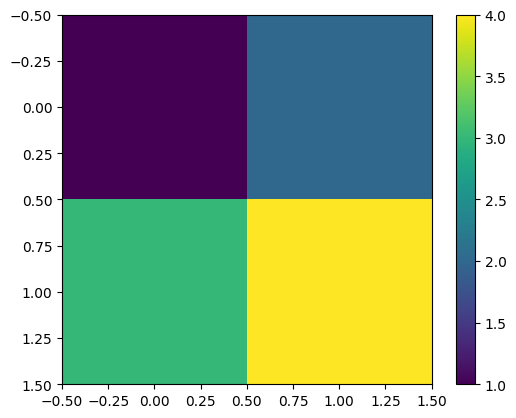

In [ ]:
a = np.array([[1, 2], [3, 4]])
print(a)
plt.imshow(a)
plt.colorbar()

[[0.80948068 0.81648551]
 [0.83297101 0.82886473]]


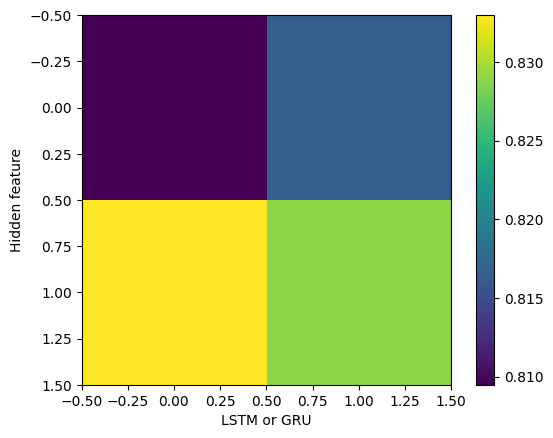

In [ ]:
plt.imshow(x[:, 0, :, 2, 1])
plt.xlabel('LSTM or GRU')
plt.ylabel('Hidden feature')
plt.colorbar()
print(x[:, 0, :, 2, 1])

[[0.81388889 0.83611111]
 [0.88055556 0.86388889]]


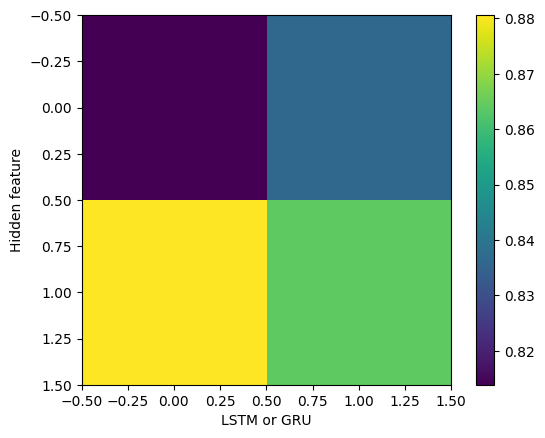

In [ ]:
plt.imshow(x[:, 0, :, 1, 1])
plt.xlabel('LSTM or GRU')
plt.ylabel('Hidden feature')
plt.colorbar()
print(x[:, 0, :, 1, 1])

### num layer = 2

In [ ]:
hidden_size_list = [8, 16]
num_layers_list = [2]
l_g = [True, False]
BATCH_SIZE = 8

In [ ]:
score = np.zeros((6, 5, len(hidden_size_list), len(num_layers_list), len(l_g), 3, 8))
# participants, folds, hidden size, layers number, LSTM or GRU, Train/Val/Test, 8score
for ID in range(1, 7):
    for folder_idx in range(1, 11, 2):
        R_time_test = [folder_idx+1, folder_idx+2 if folder_idx+2 <= 10 else folder_idx+2-10]
        test_dataset = MyDataset([ID], R_time_test)
        test_loader = Data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        R_time_val = [folder_idx]
        val_dataset = MyDataset([ID], R_time_val)
        val_loader = Data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        R_time_train = []
        for i in range(1, 11):
            if i not in R_time_test and i not in R_time_val:
                R_time_train.append(i)
        train_dataset = MyDataset([ID], R_time_train)
        train_loader = Data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        
        for hsize_idx in range(len(hidden_size_list)):
            for l_idx in range(len(num_layers_list)):
                for l_g_idx in range(len(l_g)):
                    model_param = {'LSTM': l_g[l_g_idx], 'hidden_size':hidden_size_list[hsize_idx], 'num_layers':num_layers_list[l_idx]}
                    score[ID-1, int(np.floor(folder_idx/2)), hsize_idx, l_idx, l_g_idx] = \
                        main_function(total_epoch=1000, dataloader_list=[train_loader, val_loader, test_loader], \
                            model_para=model_param, model_save=False, cross_val=True)
                    print('ID{} hidden_size{} num_layers{} LSTM{} Val Loss{}, Val Acc{}'.\
                        format(ID, hidden_size_list[hsize_idx], num_layers_list[l_idx], l_g[l_g_idx],\
                            score[ID-1, int(np.floor(folder_idx/2)), hsize_idx, l_idx, l_g_idx, 1, 0], \
                                score[ID-1, int(np.floor(folder_idx/2)), hsize_idx, l_idx, l_g_idx, 1, 1]))
                    print('ID{} hidden_size{} num_layers{} LSTM{} Test Loss{}, Test Acc{}'.\
                        format(ID, hidden_size_list[hsize_idx], num_layers_list[l_idx], l_g[l_g_idx],\
                            score[ID-1, int(np.floor(folder_idx/2)), hsize_idx, l_idx, l_g_idx, 2, 0], \
                                score[ID-1, int(np.floor(folder_idx/2)), hsize_idx, l_idx, l_g_idx, 2, 1]))
                    torch.cuda.empty_cache()
np.save(result_path+'/score_d0417_5', score)

In [ ]:
x = np.mean(np.mean(score, axis=0), axis=0)

[[0.80392512 0.83454106]
 [0.84136473 0.83315217]]


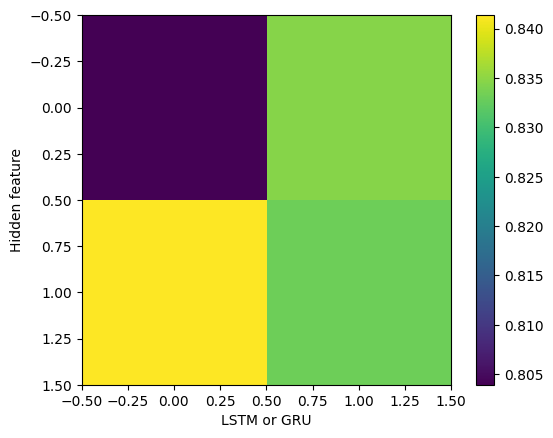

In [ ]:
plt.imshow(x[:, 0, :, 2, 1])
plt.xlabel('LSTM or GRU')
plt.ylabel('Hidden feature')
plt.colorbar()
print(x[:, 0, :, 2, 1])

In [ ]:
# LSTM GRU Test result
print(x[1, 0, 0, 2])
print(x[1, 0, 1, 2])

[0.60877132 0.84136473 0.84136473 0.82219577 0.84136473 0.83847222
 0.84136473 0.84166667]
[0.59564645 0.83315217 0.83315217 0.81931878 0.83315217 0.85087963
 0.83315217 0.83333333]


[[0.88333333 0.87222222]
 [0.9        0.88055556]]


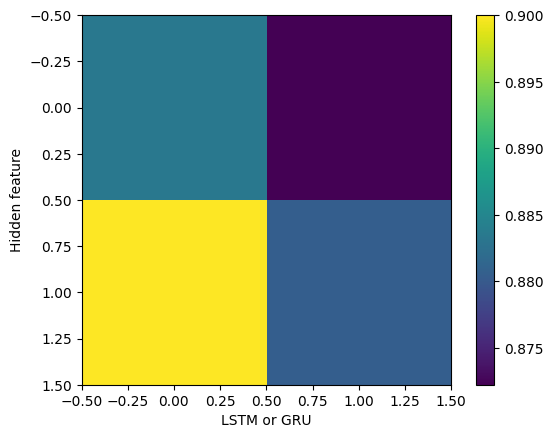

In [ ]:
plt.imshow(x[:, 0, :, 1, 1])
plt.xlabel('LSTM or GRU')
plt.ylabel('Hidden feature')
plt.colorbar()
print(x[:, 0, :, 1, 1])

Train subject model

In [ ]:
for ID in range(1, 7):
  R_time_train = []
  for i in range(1, 11):
    R_time_train.append(i)
  train_dataset = MyDataset([ID], R_time_train)
  train_loader = Data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        

  model_param = {'LSTM': l_g[0], 'hidden_size':hidden_size_list[1], 'num_layers':num_layers_list[0]}
  main_function(total_epoch=1000, dataloader_list=[train_loader],model_para=model_param, model_save=True, cross_val=False, \
                model_name = result_path + '/lstm_sub00' + str(ID) + '.pth')
  torch.cuda.empty_cache()

  model_param = {'LSTM': l_g[1], 'hidden_size':hidden_size_list[1], 'num_layers':num_layers_list[0]}
  main_function(total_epoch=1000, dataloader_list=[train_loader],model_para=model_param, model_save=True, cross_val=False, \
                model_name = result_path + '/gru_sub00' + str(ID) + '.pth')
  torch.cuda.empty_cache()


100%|██████████| 1000/1000 [01:04<00:00, 15.54it/s]


### User independent

### 1

In [ ]:
hidden_size_list = [8, 16]
num_layers_list = [2]
l_g = [True, False]
BATCH_SIZE = 64

In [ ]:
score = np.zeros((6, len(hidden_size_list), len(num_layers_list), len(l_g), 3, 8))
# participants, folds, hidden size, layers number, LSTM or GRU, Train/Val/Test, 8score
R_time_list = []
for i in range(1, 11):
  R_time_list.append(i)

for ID in range(1, 7):

    test_dataset = MyDataset([ID], R_time_list)
    test_loader = Data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    x = ID+1 if ID+1<=6 else 1
    val_dataset = MyDataset([x], R_time_list)
    val_loader = Data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
    ID_train = []
    for i in range(1, 7):
        if i != ID and i != x:
            ID_train.append(i)  
    train_dataset = MyDataset(ID_train, R_time_list)
    train_loader = Data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        
    for hsize_idx in range(len(hidden_size_list)):
        for l_idx in range(len(num_layers_list)):
            for l_g_idx in range(len(l_g)):
                model_param = {'LSTM': l_g[l_g_idx], 'hidden_size':hidden_size_list[hsize_idx], 'num_layers':num_layers_list[l_idx]}
                score[ID-1, hsize_idx, l_idx, l_g_idx] = \
                    main_function(total_epoch=1000, dataloader_list=[train_loader, val_loader, test_loader], \
                        model_para=model_param, model_save=False, cross_val=True)
                print('ID{} hidden_size{} num_layers{} LSTM{} Val Loss{}, Val Acc{}'.\
                    format(ID, hidden_size_list[hsize_idx], num_layers_list[l_idx], l_g[l_g_idx],\
                        score[ID-1, hsize_idx, l_idx, l_g_idx, 1, 0], \
                            score[ID-1, hsize_idx, l_idx, l_g_idx, 1, 1]))
                print('ID{} hidden_size{} num_layers{} LSTM{} Test Loss{}, Test Acc{}'.\
                    format(ID, hidden_size_list[hsize_idx], num_layers_list[l_idx], l_g[l_g_idx],\
                        score[ID-1, hsize_idx, l_idx, l_g_idx, 2, 0], \
                            score[ID-1, hsize_idx, l_idx, l_g_idx, 2, 1]))
                torch.cuda.empty_cache()

np.save(result_path+'/score_d0417_6', score)

In [ ]:
x = np.mean(score, axis=0)

[[0.67883987 0.64549486]
 [0.63992764 0.65106209]]


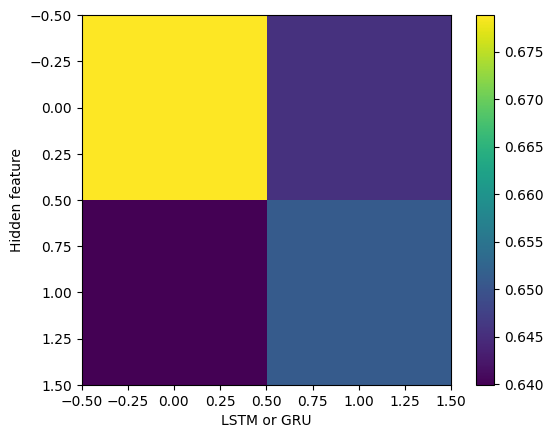

In [ ]:
plt.imshow(x[:, 0, :, 2, 1])
plt.xlabel('LSTM or GRU')
plt.ylabel('Hidden feature')
plt.colorbar()
print(x[:, 0, :, 2, 1])

[[0.68580766 0.67892157]
 [0.70806489 0.67059991]]


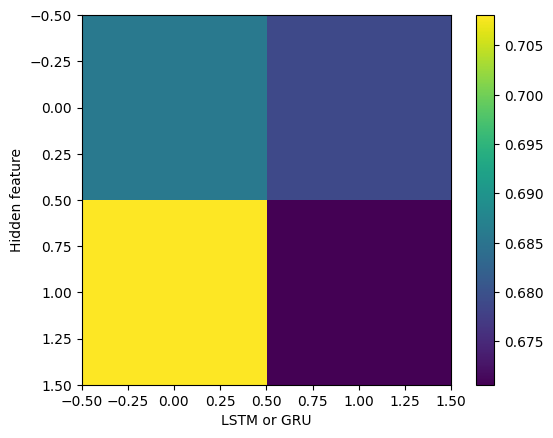

In [ ]:
plt.imshow(x[:, 0, :, 1, 1])
plt.xlabel('LSTM or GRU')
plt.ylabel('Hidden feature')
plt.colorbar()
print(x[:, 0, :, 1, 1])

### 2

In [ ]:
hidden_size_list = [8, 16]
num_layers_list = [2]
l_g = [True, False]
BATCH_SIZE = 64

In [ ]:
score = np.zeros((6, len(hidden_size_list), len(num_layers_list), len(l_g), 3, 8))
# participants, folds, hidden size, layers number, LSTM or GRU, Train/Val/Test, 8score
R_time_list = []
for i in range(1, 11):
  R_time_list.append(i)

for ID in range(1, 7):

    test_dataset = MyDataset([ID], R_time_list)
    test_loader = Data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    x = ID+1 if ID+1<=6 else 1
    val_dataset = MyDataset([x], R_time_list)
    val_loader = Data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
    ID_train = []
    for i in range(1, 7):
        if i != ID and i != x:
            ID_train.append(i)  
    train_dataset = MyDataset(ID_train, R_time_list)
    train_loader = Data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        
    for hsize_idx in range(len(hidden_size_list)):
        for l_idx in range(len(num_layers_list)):
            for l_g_idx in range(len(l_g)):
                model_param = {'LSTM': l_g[l_g_idx], 'hidden_size':hidden_size_list[hsize_idx], 'num_layers':num_layers_list[l_idx]}
                score[ID-1, hsize_idx, l_idx, l_g_idx] = \
                    main_function(total_epoch=1000, dataloader_list=[train_loader, val_loader, test_loader], \
                        model_para=model_param, model_save=False, cross_val=True)
                print('ID{} hidden_size{} num_layers{} LSTM{} Val Loss{}, Val Acc{}'.\
                    format(ID, hidden_size_list[hsize_idx], num_layers_list[l_idx], l_g[l_g_idx],\
                        score[ID-1, hsize_idx, l_idx, l_g_idx, 1, 0], \
                            score[ID-1, hsize_idx, l_idx, l_g_idx, 1, 1]))
                print('ID{} hidden_size{} num_layers{} LSTM{} Test Loss{}, Test Acc{}'.\
                    format(ID, hidden_size_list[hsize_idx], num_layers_list[l_idx], l_g[l_g_idx],\
                        score[ID-1, hsize_idx, l_idx, l_g_idx, 2, 0], \
                            score[ID-1, hsize_idx, l_idx, l_g_idx, 2, 1]))
                torch.cuda.empty_cache()

np.save(result_path+'/score_d0417_7', score)

In [ ]:
x = np.mean(score, axis=0)

[[0.66077264 0.68429038]
 [0.63851541 0.65514706]]


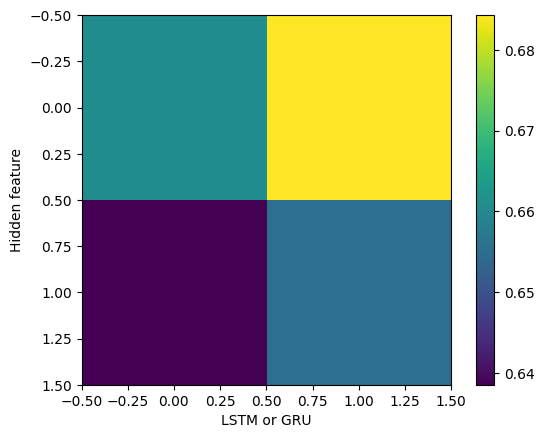

In [ ]:
plt.imshow(x[:, 0, :, 2, 1])
plt.xlabel('LSTM or GRU')
plt.ylabel('Hidden feature')
plt.colorbar()
print(x[:, 0, :, 2, 1])

In [ ]:
# Result All subject
print(x[0, 0, 0, 2, :])
print(x[0, 0, 1, 2, :])

[1.24599711 0.66077264 0.66077264 0.63349127 0.66077264 0.69234297
 0.66077264 0.66111111]
[1.1152162  0.68429038 0.68429038 0.65278579 0.68429038 0.71889459
 0.68429038 0.68472222]


[[0.67741597 0.66498599]
 [0.67189542 0.67197712]]


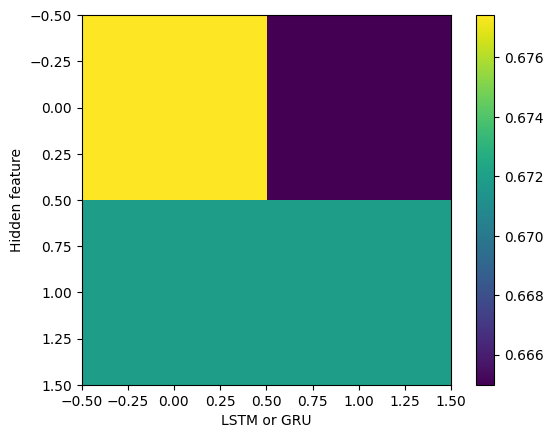

In [ ]:
plt.imshow(x[:, 0, :, 1, 1])
plt.xlabel('LSTM or GRU')
plt.ylabel('Hidden feature')
plt.colorbar()
print(x[:, 0, :, 1, 1])

Train model

In [ ]:
ID_train = []
for ID in range(1, 7):
  ID_train.append(ID)
R_time_train = []
for i in range(1, 11):
  R_time_train.append(i)
train_dataset = MyDataset([ID], R_time_train)
train_loader = Data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        

model_param = {'LSTM': l_g[0], 'hidden_size':hidden_size_list[0], 'num_layers':num_layers_list[0]}
main_function(total_epoch=1000, dataloader_list=[train_loader],model_para=model_param, model_save=True, cross_val=False, \
                model_name = result_path + '/lstm_subAll.pth')
torch.cuda.empty_cache()

model_param = {'LSTM': l_g[1], 'hidden_size':hidden_size_list[0], 'num_layers':num_layers_list[0]}
main_function(total_epoch=1000, dataloader_list=[train_loader],model_para=model_param, model_save=True, cross_val=False, \
                model_name = result_path + '/gru_subAll.pth')
torch.cuda.empty_cache()


100%|██████████| 1000/1000 [00:19<00:00, 50.01it/s]


# show data

torch.Size([84, 100, 2]) torch.Size([84]) [ 0  1  2  3  4  5  6  7  8  9 10 11]
0 7
1 7
2 7
3 7
4 7
5 7
6 7
7 7
8 7
9 7
10 7
11 7


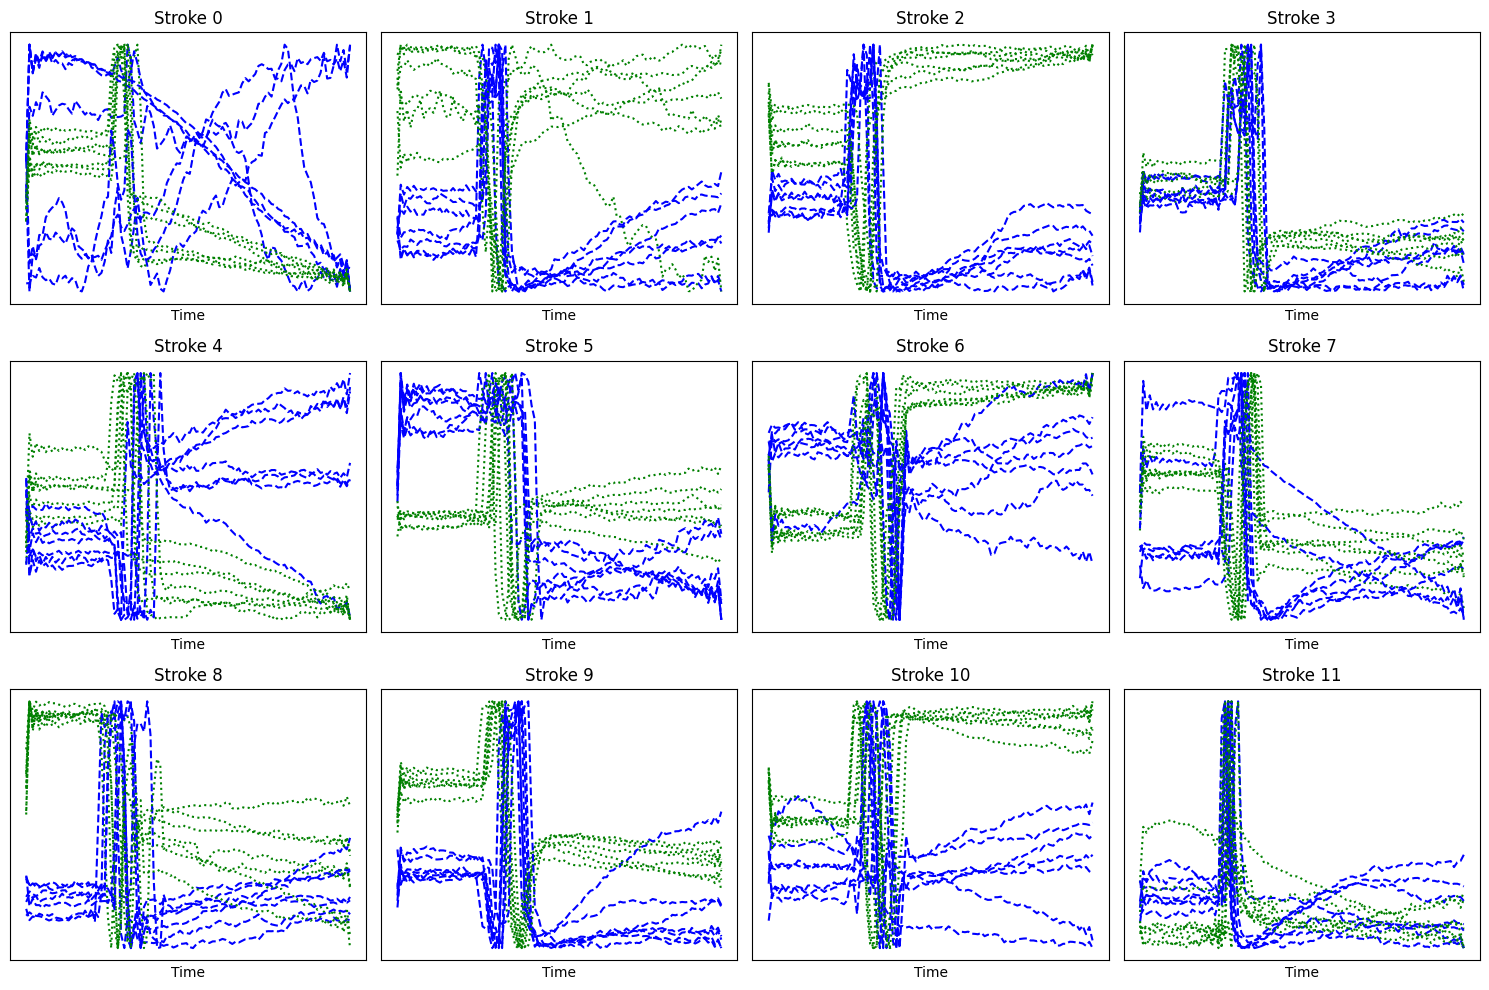

torch.Size([12, 100, 2]) torch.Size([12]) [ 0  1  2  3  4  5  6  7  8  9 10 11]
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1


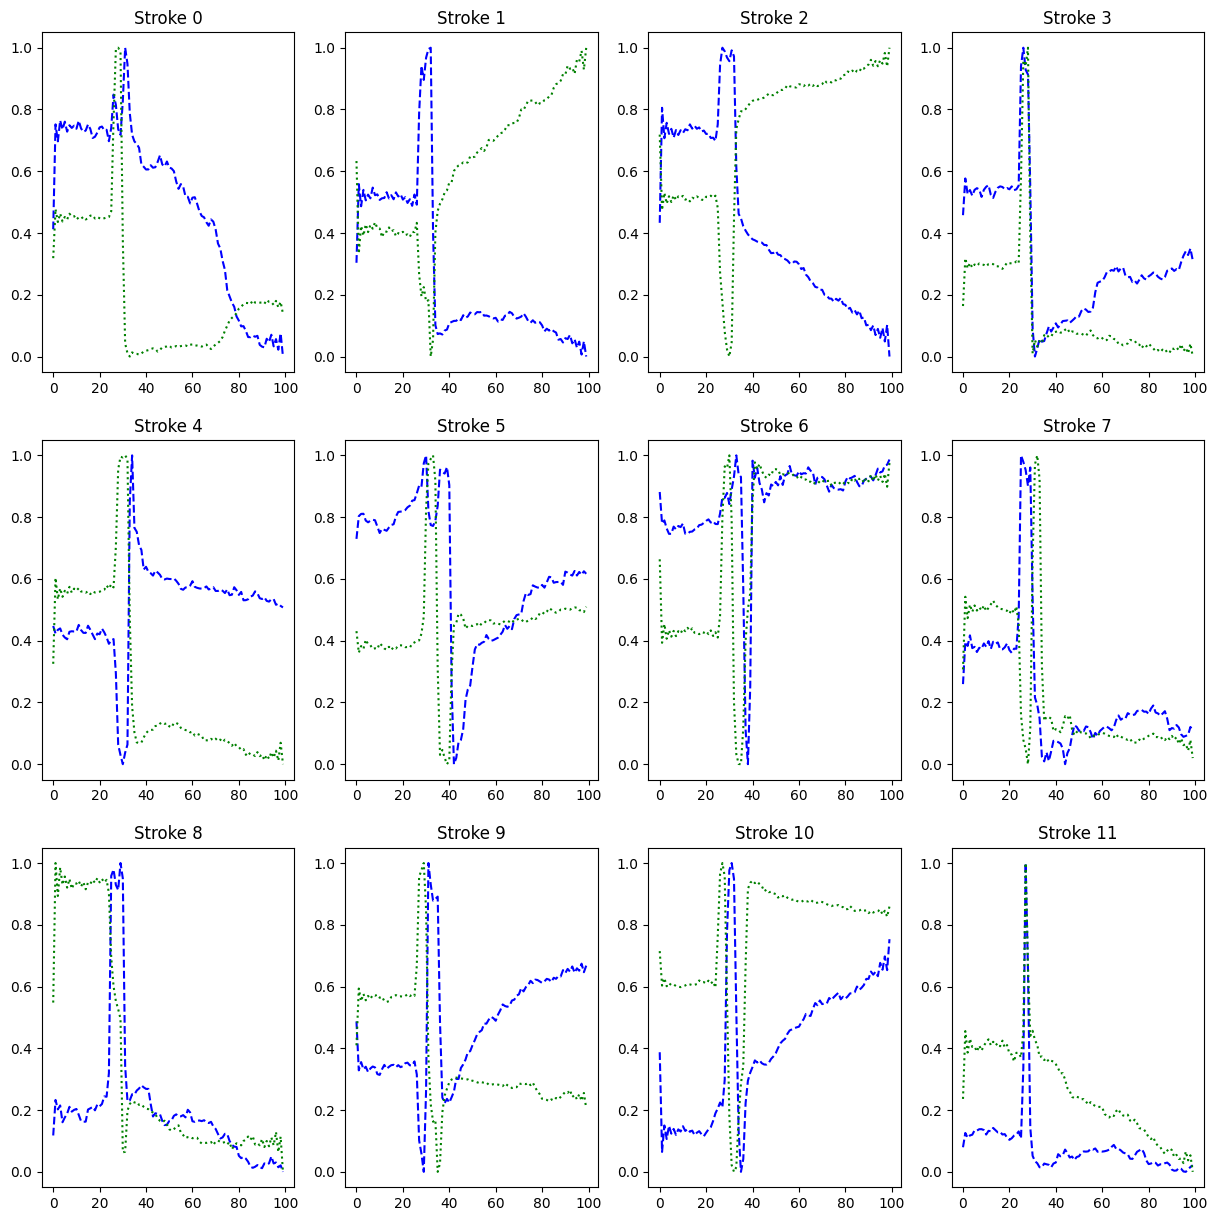

torch.Size([24, 100, 2]) torch.Size([24]) [ 0  1  2  3  4  5  6  7  8  9 10 11]
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
10 2
11 2


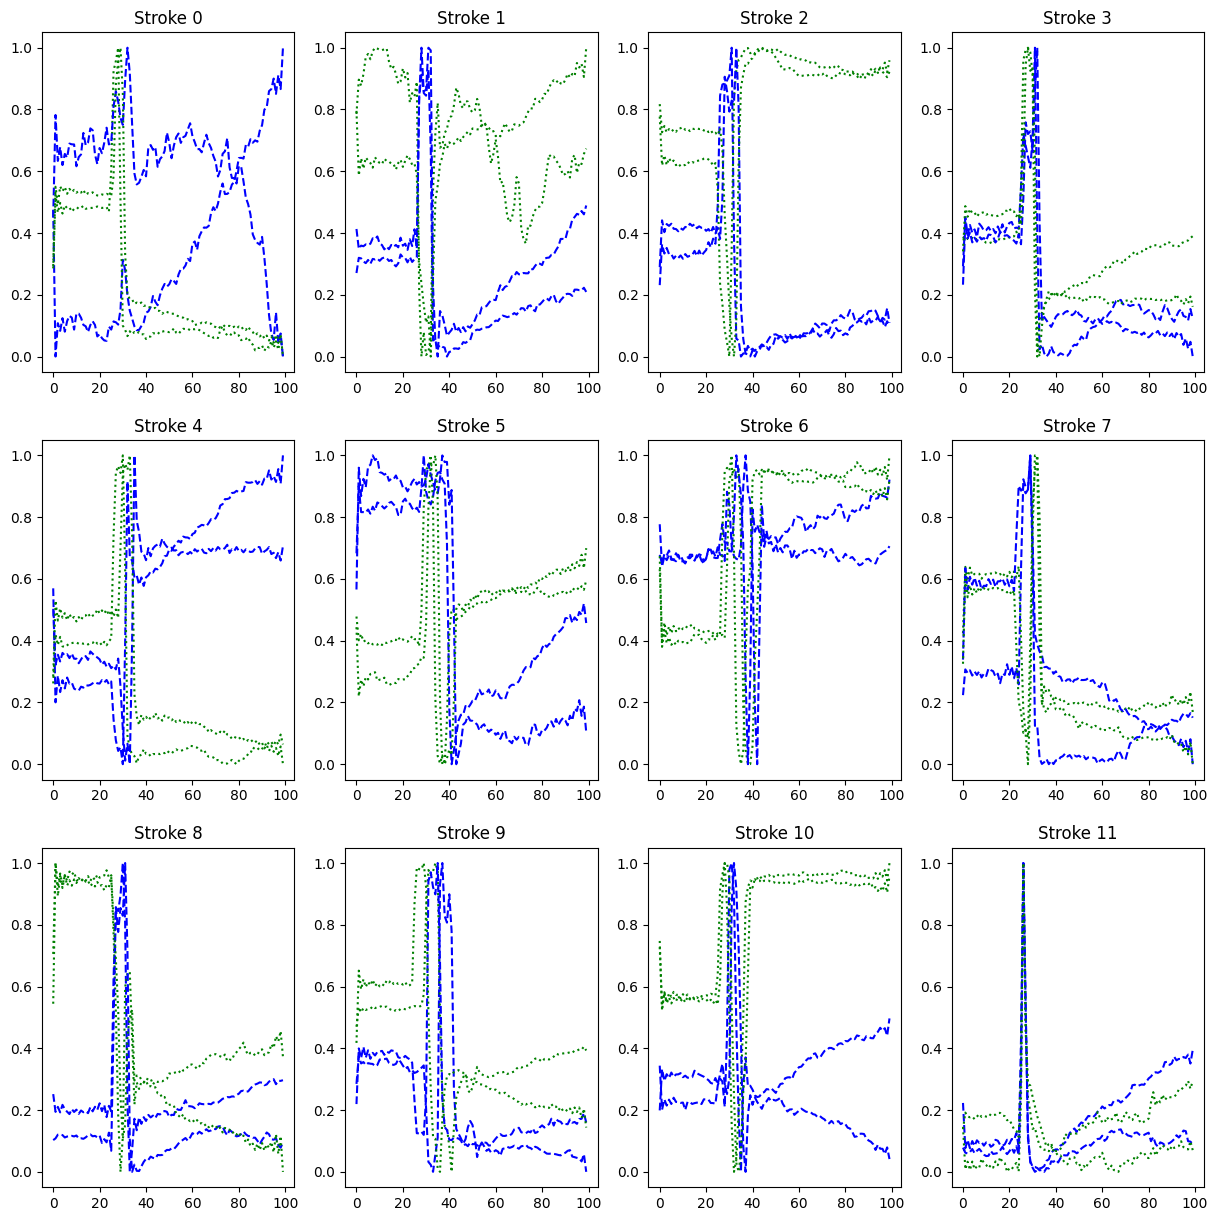

In [13]:
BATCH_SIZE = 64
for ID in range(1, 7):
    for folder_idx in range(1, 11, 2):
        R_time_test = [folder_idx+1, folder_idx+2 if folder_idx+2 <= 10 else folder_idx+2-10]
        test_dataset = MyDataset([ID], R_time_test)
        test_loader = Data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        R_time_val = [folder_idx]
        val_dataset = MyDataset([ID], R_time_val)
        val_loader = Data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        R_time_train = []
        for i in range(1, 11):
            if i not in R_time_test and i not in R_time_val:
                R_time_train.append(i)
        train_dataset = MyDataset([ID], R_time_train)
        train_loader = Data.DataLoader(train_dataset, batch_size=1000, shuffle=True)

        plt.figure(1, figsize=(15, 10))
        for data, label in train_loader:
            print(data.shape, label.shape, np.unique(label.numpy()))
            for i in range(12):
                print(i, np.sum(label.numpy()==i))
                plt.subplot(3, 4, i+1)
                for j in range(label.shape[0]):
                    if label[j].item() == i:
                        plt.plot(data[j, :, 0], '--b',label='V')
                        plt.plot(data[j, :, 1], ':g',label='H')
                        plt.xticks([], [])
                        plt.yticks([], [])
                        plt.xlabel('Time')
                plt.title('Stroke ' + str(i))
                #plt.legend(loc='right')
        plt.tight_layout()
        plt.show()
        plt.figure(2, figsize=(15, 15))
        for data, label in val_loader:
            print(data.shape, label.shape, np.unique(label.numpy()))
            for i in range(12):
                print(i, np.sum(label.numpy()==i))
                plt.subplot(3, 4, i+1)
                for j in range(label.shape[0]):
                    if label[j].item() == i:
                        plt.plot(data[j, :, 0], '--b',label='V')
                        plt.plot(data[j, :, 1], ':g',label='H')
                #plt.legend(loc='right')
                plt.title('Stroke ' + str(i))
        plt.show()
        plt.figure(3, figsize=(15, 15))
        for data, label in test_loader:
            print(data.shape, label.shape, np.unique(label.numpy()))
            for i in range(12):
                print(i, np.sum(label.numpy()==i))
                plt.subplot(3, 4, i+1)
                for j in range(label.shape[0]):
                    if label[j].item() == i:
                        plt.plot(data[j, :, 0], '--b',label='V')
                        plt.plot(data[j, :, 1], ':g',label='H')
                #plt.legend(loc='right')
                plt.title('Stroke ' + str(i))
        plt.show()
        break
    break

torch.Size([84, 100, 2]) torch.Size([84]) [ 0  1  2  3  4  5  6  7  8  9 10 11]
0 7
1 7
2 7
3 7
4 7
5 7
6 7
7 7
8 7
9 7
10 7
11 7


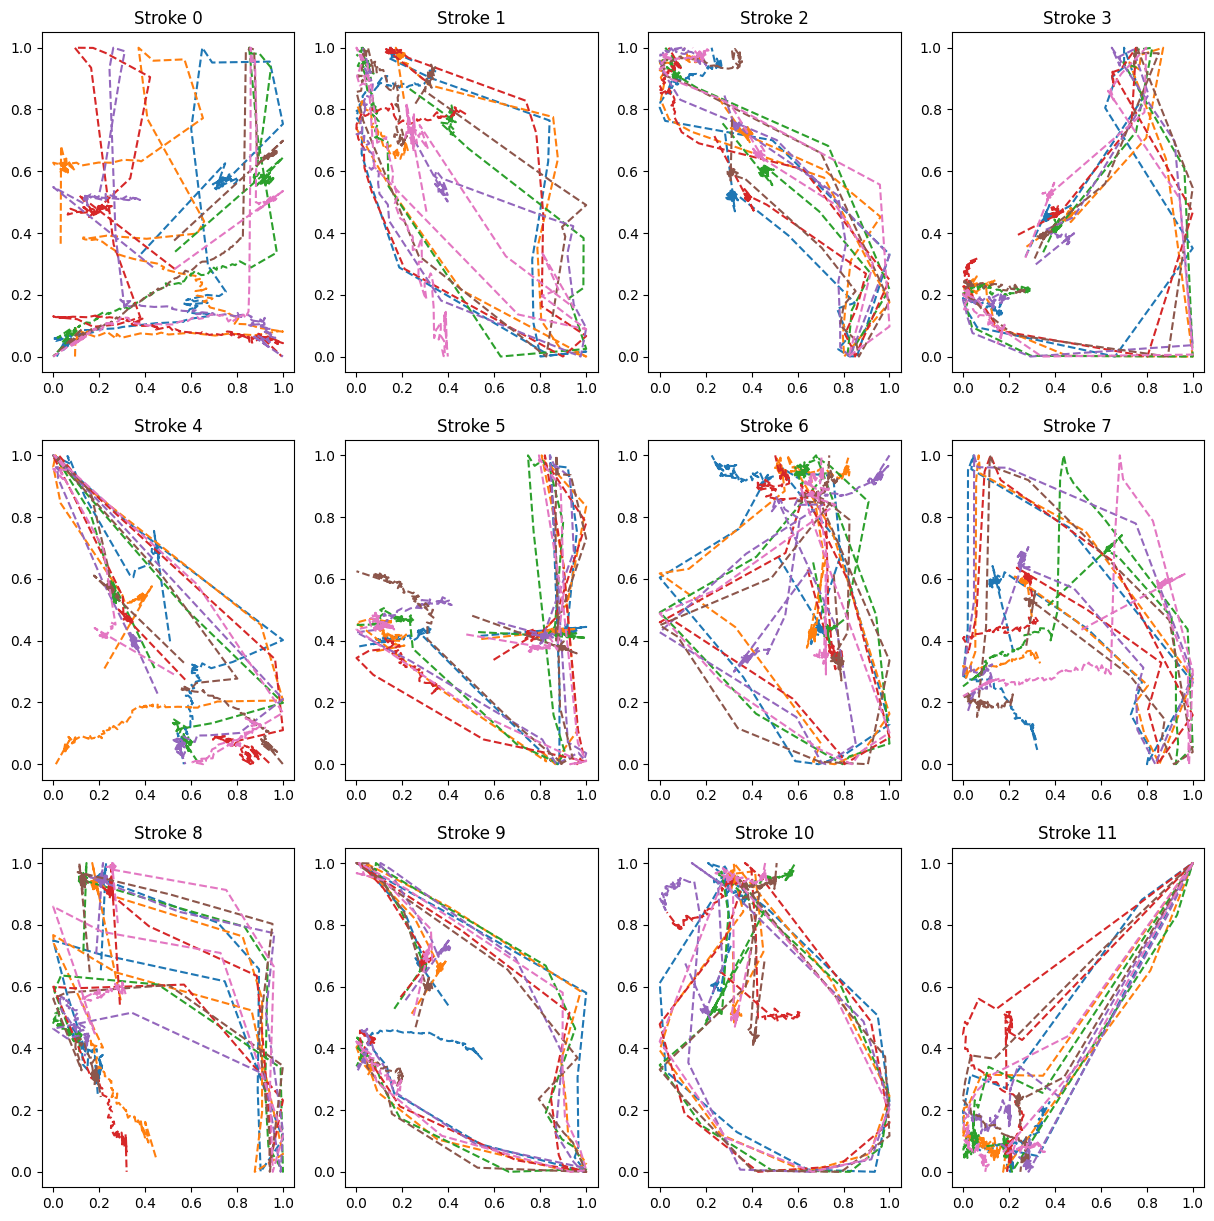

torch.Size([12, 100, 2]) torch.Size([12]) [ 0  1  2  3  4  5  6  7  8  9 10 11]
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1


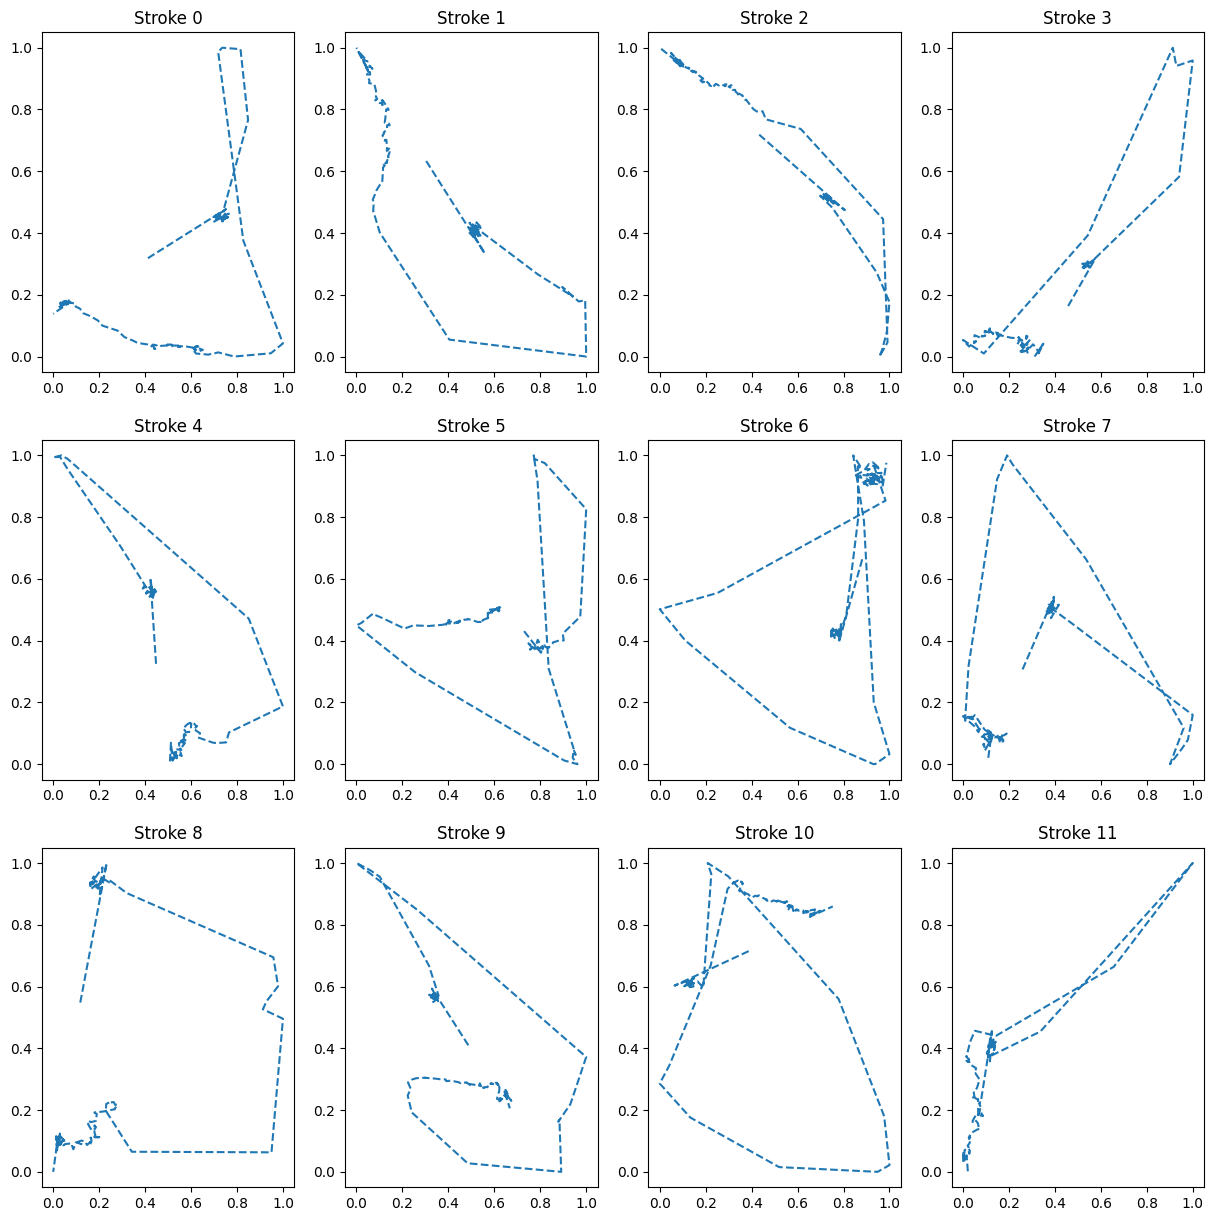

torch.Size([24, 100, 2]) torch.Size([24]) [ 0  1  2  3  4  5  6  7  8  9 10 11]
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
10 2
11 2


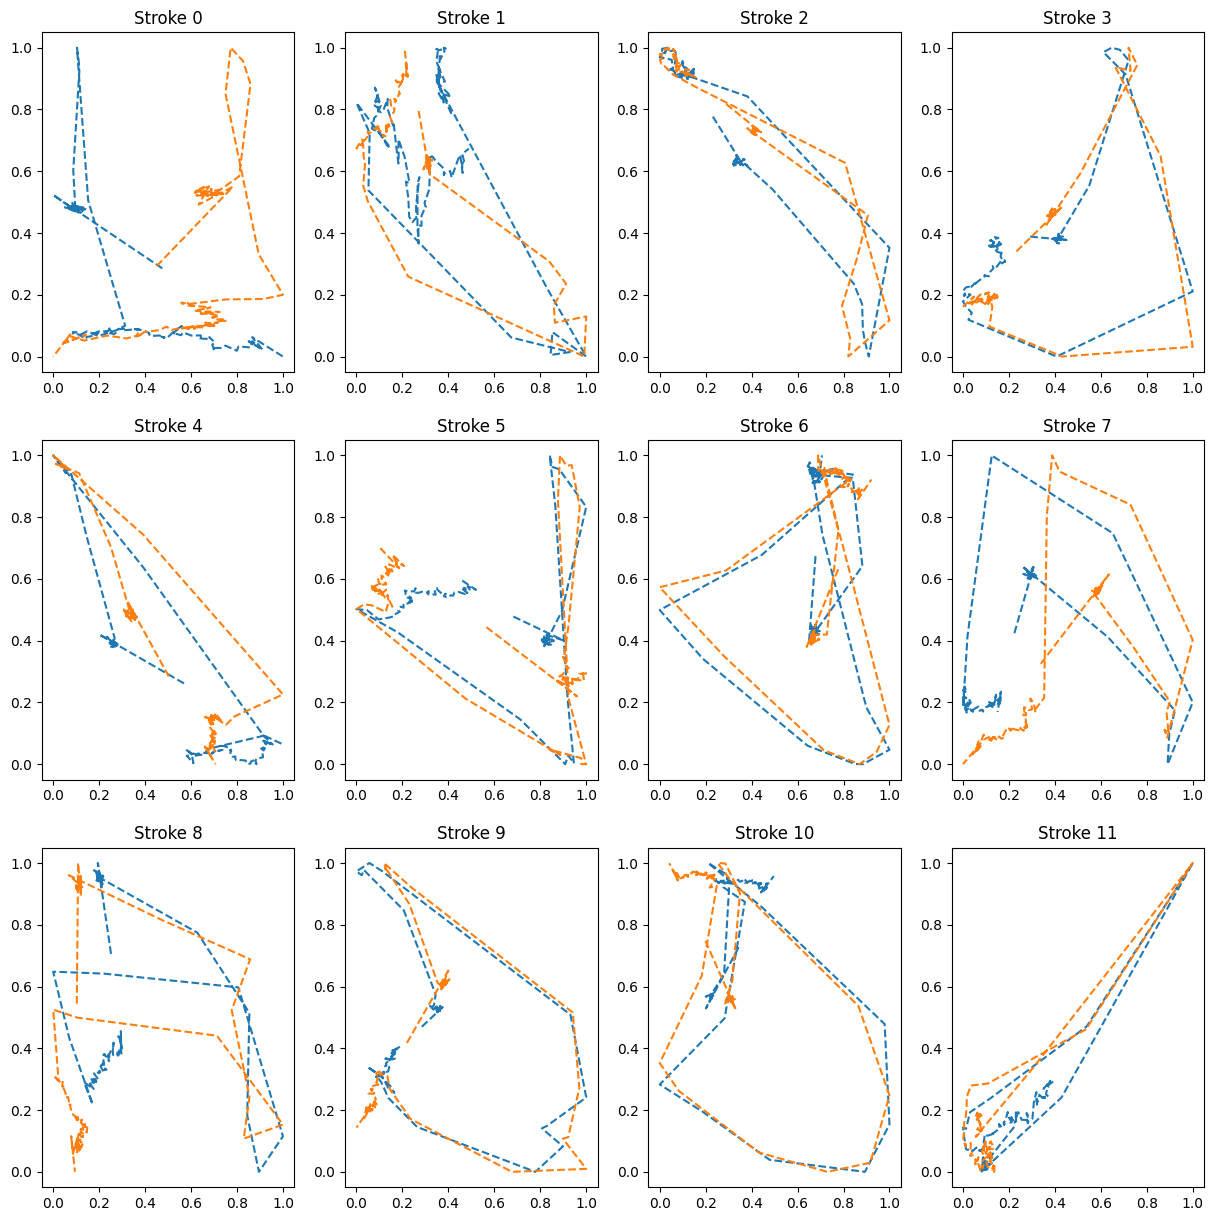

In [ ]:
for ID in range(1, 7):
    for folder_idx in range(1, 11, 2):
        R_time_test = [folder_idx+1, folder_idx+2 if folder_idx+2 <= 10 else folder_idx+2-10]
        test_dataset = MyDataset(ID, R_time_test)
        test_loader = Data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        R_time_val = [folder_idx]
        val_dataset = MyDataset(ID, R_time_val)
        val_loader = Data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        R_time_train = []
        for i in range(1, 11):
            if i not in R_time_test and i not in R_time_val:
                R_time_train.append(i)
        train_dataset = MyDataset(ID, R_time_train)
        train_loader = Data.DataLoader(train_dataset, batch_size=1000, shuffle=True)

        plt.figure(1, figsize=(15, 15))
        for data, label in train_loader:
            print(data.shape, label.shape, np.unique(label.numpy()))
            for i in range(12):
                print(i, np.sum(label.numpy()==i))
                plt.subplot(3, 4, i+1)
                for j in range(label.shape[0]):
                    if label[j].item() == i:
                        plt.plot(data[j, :, 0], data[j, :, 1], '--')
                plt.title('Stroke ' + str(i))
        plt.show()
        plt.figure(2, figsize=(15, 15))
        for data, label in val_loader:
            print(data.shape, label.shape, np.unique(label.numpy()))
            for i in range(12):
                print(i, np.sum(label.numpy()==i))
                plt.subplot(3, 4, i+1)
                for j in range(label.shape[0]):
                    if label[j].item() == i:
                        plt.plot(data[j, :, 0], data[j, :, 1], '--')
                plt.title('Stroke ' + str(i))
        plt.show()
        plt.figure(3, figsize=(15, 15))
        for data, label in test_loader:
            print(data.shape, label.shape, np.unique(label.numpy()))
            for i in range(12):
                print(i, np.sum(label.numpy()==i))
                plt.subplot(3, 4, i+1)
                for j in range(label.shape[0]):
                    if label[j].item() == i:
                        plt.plot(data[j, :, 0], data[j, :, 1], '--')
                plt.title('Stroke ' + str(i))
        plt.show()
        break
    break

torch.Size([84, 100, 2]) torch.Size([84]) [ 0  1  2  3  4  5  6  7  8  9 10 11]
0 7
1 7
2 7
3 7
4 7
5 7
6 7
7 7
8 7
9 7
10 7
11 7


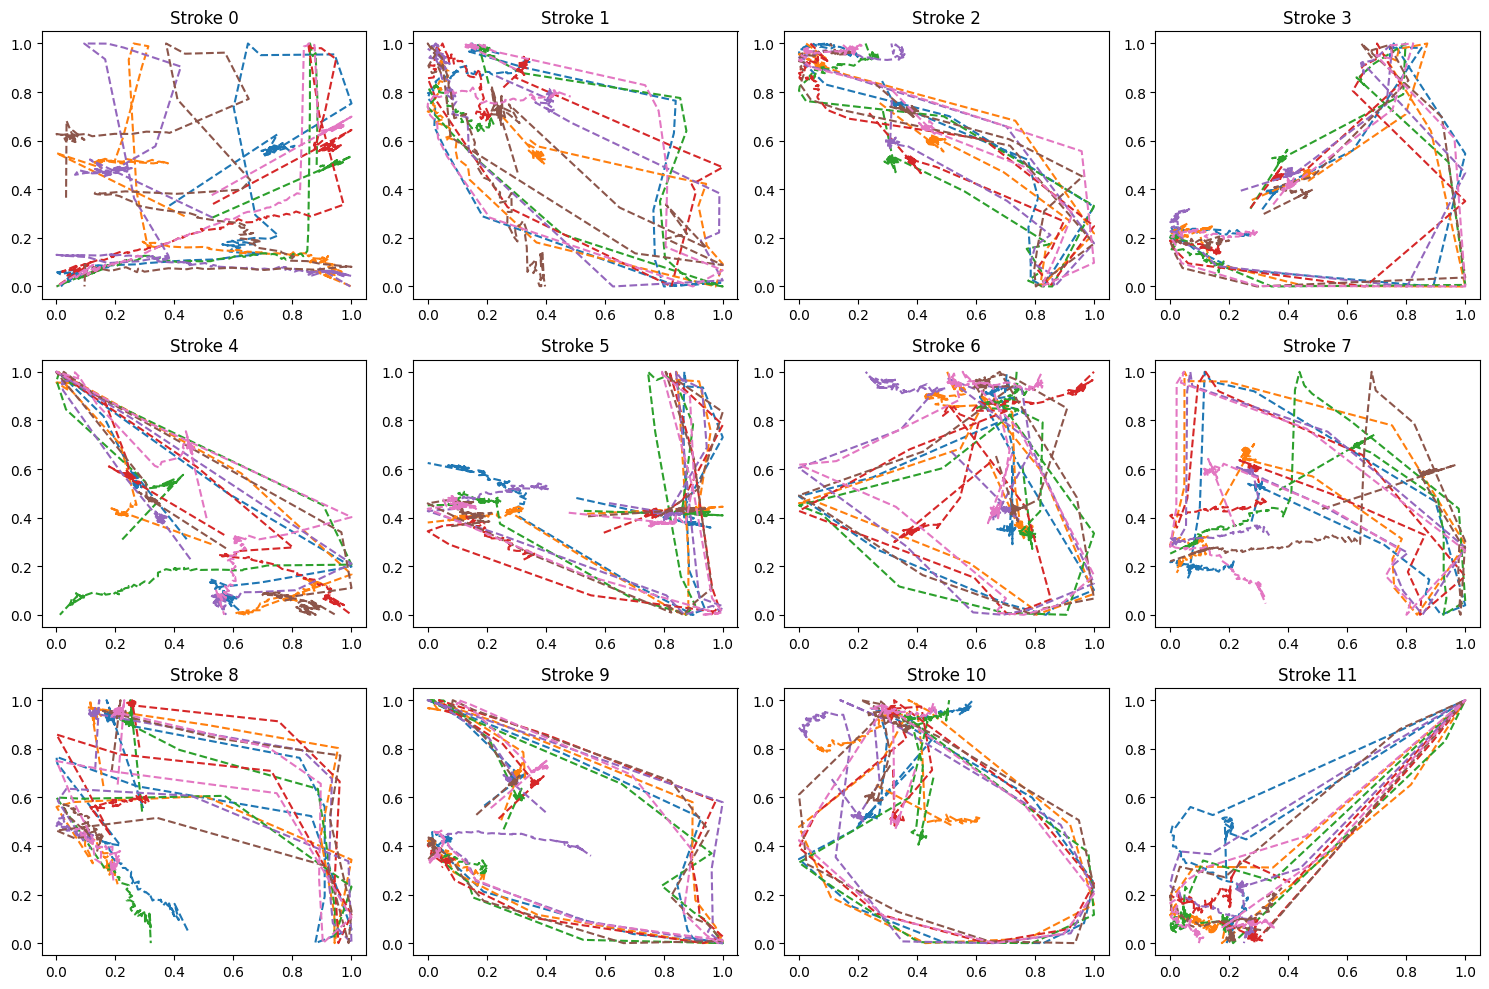

torch.Size([12, 100, 2]) torch.Size([12]) [ 0  1  2  3  4  5  6  7  8  9 10 11]
0 1
1 1
2 1
3 1
4 1
5 1
6 1
7 1
8 1
9 1
10 1
11 1


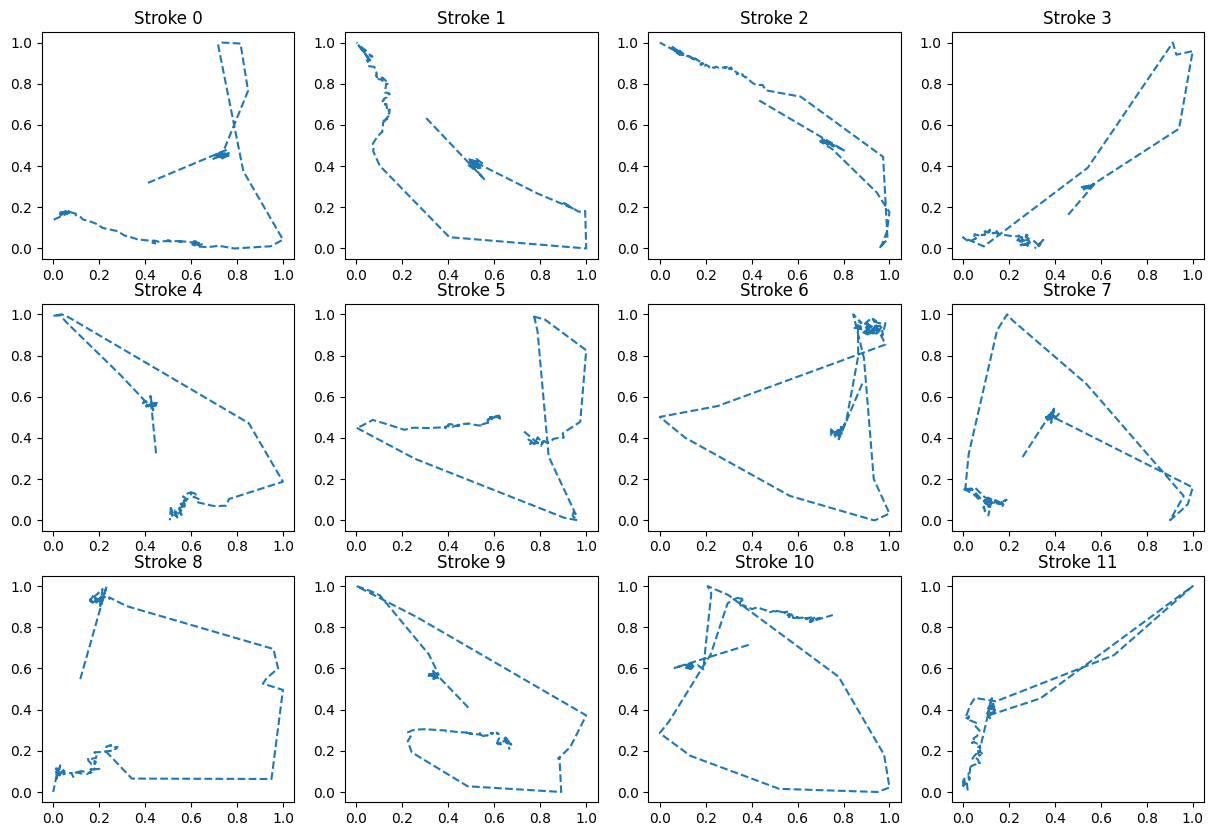

torch.Size([24, 100, 2]) torch.Size([24]) [ 0  1  2  3  4  5  6  7  8  9 10 11]
0 2
1 2
2 2
3 2
4 2
5 2
6 2
7 2
8 2
9 2
10 2
11 2


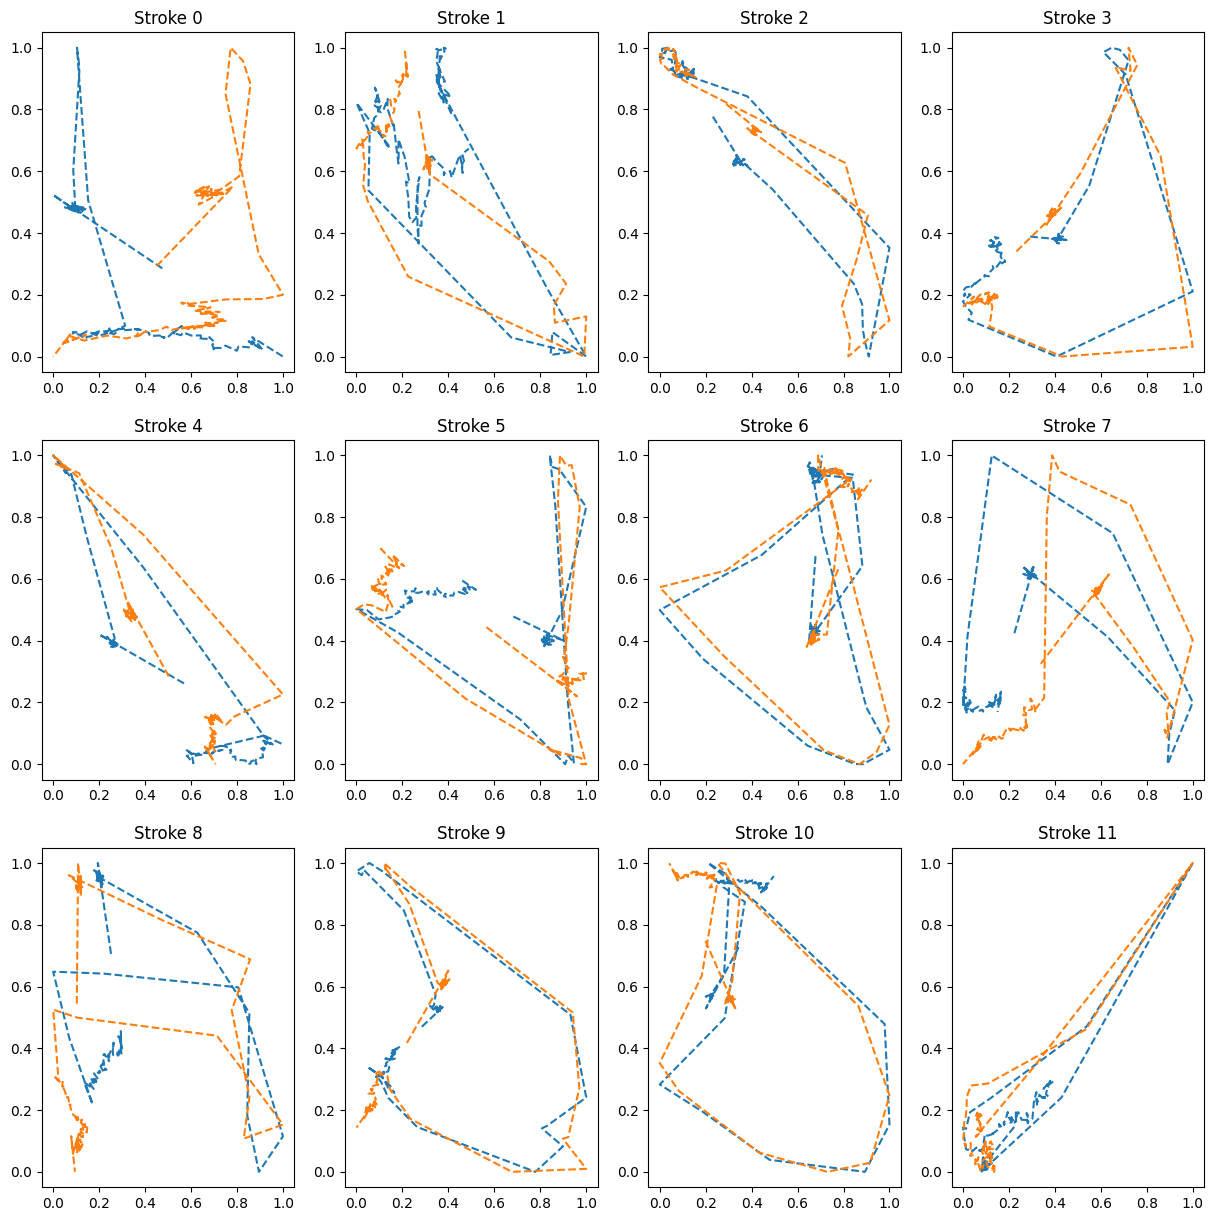

In [16]:
for ID in range(1, 7):
    for folder_idx in range(1, 11, 2):
        R_time_test = [folder_idx+1, folder_idx+2 if folder_idx+2 <= 10 else folder_idx+2-10]
        test_dataset = MyDataset([ID], R_time_test)
        test_loader = Data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        R_time_val = [folder_idx]
        val_dataset = MyDataset([ID], R_time_val)
        val_loader = Data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
        
        R_time_train = []
        for i in range(1, 11):
            if i not in R_time_test and i not in R_time_val:
                R_time_train.append(i)
        train_dataset = MyDataset([ID], R_time_train)
        train_loader = Data.DataLoader(train_dataset, batch_size=1000, shuffle=True)

        plt.figure(1, figsize=(15, 10))
        for data, label in train_loader:
            print(data.shape, label.shape, np.unique(label.numpy()))
            for i in range(12):
                print(i, np.sum(label.numpy()==i))
                plt.subplot(3, 4, i+1)
                for j in range(label.shape[0]):
                    if label[j].item() == i:
                        plt.plot(data[j, :, 0], data[j, :, 1], '--')
                plt.title('Stroke ' + str(i))
        plt.tight_layout()
        plt.show()
        plt.figure(2, figsize=(15, 10))
        for data, label in val_loader:
            print(data.shape, label.shape, np.unique(label.numpy()))
            for i in range(12):
                print(i, np.sum(label.numpy()==i))
                plt.subplot(3, 4, i+1)
                for j in range(label.shape[0]):
                    if label[j].item() == i:
                        plt.plot(data[j, :, 0], data[j, :, 1], '--')
                plt.title('Stroke ' + str(i))
        plt.show()
        plt.figure(3, figsize=(15, 15))
        for data, label in test_loader:
            print(data.shape, label.shape, np.unique(label.numpy()))
            for i in range(12):
                print(i, np.sum(label.numpy()==i))
                plt.subplot(3, 4, i+1)
                for j in range(label.shape[0]):
                    if label[j].item() == i:
                        plt.plot(data[j, :, 0], data[j, :, 1], '--')
                plt.title('Stroke ' + str(i))
        plt.show()
        break
    break

In [ ]:
def scores(y_true, y_pred):
  s = np.zeros((7,))
  s[0] = accuracy_score(y_true, y_pred)
  s[1] = f1_score(y_true, y_pred, average='micro', zero_division=0)
  s[2] = f1_score(y_true, y_pred, average='macro', zero_division=0)
  s[3] = precision_score(y_true, y_pred, average='micro', zero_division=0)
  s[4] = precision_score(y_true, y_pred, average='macro', zero_division=0)
  s[5] = recall_score(y_true, y_pred, average='micro', zero_division=0)
  s[6] = recall_score(y_true, y_pred, average='macro', zero_division=0)
  return s

In [ ]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from tqdm import tqdm

In [ ]:
y_pred = clf.predict(train_dataset.data.numpy().reshape(-1, 200))

In [ ]:
from sklearn.neural_network import MLPClassifier
score = np.zeros((7, 5, 2, 2, 7))
for ID in range(1, 7):
    for folder_idx in tqdm(range(1, 11, 2)):
        R_time_test = [folder_idx, folder_idx+1]
        test_dataset = MyDataset(ID, R_time_test)
        
        R_time_train = []
        for i in range(1, 11):
            if i not in R_time_test:
                R_time_train.append(i)
        train_dataset = MyDataset(ID, R_time_train)


        clf = MLPClassifier(random_state=1, max_iter=500, hidden_layer_sizes=[50, 25]) #, early_stopping=True)
        clf.fit(train_dataset.data.numpy().reshape(-1, 200), train_dataset.label.numpy())

        y_pred = clf.predict(train_dataset.data.numpy().reshape(-1, 200))
        y_true = train_dataset.label.numpy()
        score[ID-1, int(np.floor(folder_idx/2)), 0, 0, :] = scores(y_true, y_pred)

        y_pred = clf.predict(test_dataset.data.numpy().reshape(-1, 200))
        y_true = test_dataset.label.numpy()
        score[ID-1, int(np.floor(folder_idx/2)), 0, 1, :] = scores(y_true, y_pred)


        clf = MLPClassifier(random_state=1, max_iter=500, hidden_layer_sizes=[50]) #, early_stopping=True)
        clf.fit(train_dataset.data.numpy().reshape(-1, 200), train_dataset.label.numpy())

        y_pred = clf.predict(train_dataset.data.numpy().reshape(-1, 200))
        y_true = train_dataset.label.numpy()
        score[ID-1, int(np.floor(folder_idx/2)), 1, 0, :] = scores(y_true, y_pred)

        y_pred = clf.predict(test_dataset.data.numpy().reshape(-1, 200))
        y_true = test_dataset.label.numpy()
        score[ID-1, int(np.floor(folder_idx/2)), 1, 1, :] = scores(y_true, y_pred)


In [ ]:
np.save(result_path + '/d0418_2_score', score)

In [ ]:
x = np.mean(np.mean(score, axis=0), axis=0)

In [ ]:
print(x[:, 1])

[[0.723706   0.723706   0.71197279 0.723706   0.73789683 0.723706
  0.72380952]
 [0.73317805 0.73317805 0.7237415  0.73317805 0.74857143 0.73317805
  0.73333333]]


# MLP

## User Dependent

In [ ]:
from sklearn.neural_network import MLPClassifier
score = np.zeros((6, 5, 2, 2, 7))
for ID in range(1, 7):
    for folder_idx in tqdm(range(1, 11, 2)):
        R_time_test = [folder_idx, folder_idx+1]
        test_dataset = MyDataset(ID, R_time_test)
        
        R_time_train = []
        for i in range(1, 11):
            if i not in R_time_test:
                R_time_train.append(i)
        train_dataset = MyDataset(ID, R_time_train)


        clf = MLPClassifier(random_state=1, max_iter=1500, hidden_layer_sizes=[50, 25])#, early_stopping=True)
        clf.fit(train_dataset.data.numpy().reshape(-1, 200), train_dataset.label.numpy())

        y_pred = clf.predict(train_dataset.data.numpy().reshape(-1, 200))
        y_true = train_dataset.label.numpy()
        score[ID-1, int(np.floor(folder_idx/2)), 0, 0, :] = scores(y_true, y_pred)

        y_pred = clf.predict(test_dataset.data.numpy().reshape(-1, 200))
        y_true = test_dataset.label.numpy()
        score[ID-1, int(np.floor(folder_idx/2)), 0, 1, :] = scores(y_true, y_pred)


        clf = MLPClassifier(random_state=1, max_iter=1500, hidden_layer_sizes=[50])#, early_stopping=True)
        clf.fit(train_dataset.data.numpy().reshape(-1, 200), train_dataset.label.numpy())

        y_pred = clf.predict(train_dataset.data.numpy().reshape(-1, 200))
        y_true = train_dataset.label.numpy()
        score[ID-1, int(np.floor(folder_idx/2)), 1, 0, :] = scores(y_true, y_pred)

        y_pred = clf.predict(test_dataset.data.numpy().reshape(-1, 200))
        y_true = test_dataset.label.numpy()
        score[ID-1, int(np.floor(folder_idx/2)), 1, 1, :] = scores(y_true, y_pred)


100%|██████████| 5/5 [00:08<00:00,  1.79s/it]


In [ ]:
np.save(result_path + '/d0418_3_score', score)

In [ ]:
score = np.load(result_path + '/d0418_3_score.npy')

In [ ]:
x = np.mean(np.mean(score, axis=0), axis=0)

In [ ]:
print(x[:, 1])

[[0.84432367 0.84432367 0.83063492 0.84432367 0.86087963 0.84432367
  0.84444444]
 [0.8553744  0.8553744  0.84436508 0.8553744  0.87333333 0.8553744
  0.85555556]]


In [ ]:
import pickle

In [ ]:
from sklearn.neural_network import MLPClassifier
score = np.zeros((7, 5, 2, 2, 7))
for ID in range(1, 7):
  R_time_train = []
  for i in range(1, 11):
    R_time_train.append(i)
  train_dataset = MyDataset([ID], R_time_train)
  
  clf = MLPClassifier(random_state=1, max_iter=1500, hidden_layer_sizes=[50], early_stopping=True)
  clf.fit(train_dataset.data.numpy().reshape(-1, 200), train_dataset.label.numpy())
  p1 = clf.predict(train_dataset.data.numpy().reshape(-1, 200))

  model_name = result_path + '/mlp_sub00' + str(ID) + '.pck'
  # save model
  pickle.dump(clf, open(model_name, "wb"))
  # load model
  loaded_model = pickle.load(open(model_name, "rb")) 
  p2 = loaded_model.predict(train_dataset.data.numpy().reshape(-1, 200))
  if np.allclose(p1, p2):
    print('After saving, the loaded model is still same.')
  else:
    print('After saving, the loaded model changes.')

After saving, the loaded model is still same.
After saving, the loaded model is still same.
After saving, the loaded model is still same.
After saving, the loaded model is still same.
After saving, the loaded model is still same.
After saving, the loaded model is still same.


## User Independent

In [ ]:
from sklearn.neural_network import MLPClassifier
score = np.zeros((6, 4, 2, 7))
for ID in tqdm(range(1, 7)):
  R_list = []
  for i in range(1, 11):
    R_list.append(i)
  test_dataset = MyDataset([ID], R_time_test)
  ID_train = []
  for i in range(1, 7):
    if i != ID:
      ID_train.append(i)
  train_dataset = MyDataset(ID_train, R_list)
  
  print(train_dataset.data.numpy().shape, train_dataset.label.numpy().shape)
  clf = MLPClassifier(random_state=1, max_iter=1500, hidden_layer_sizes=[50, 25])#, early_stopping=True)
  clf.fit(train_dataset.data.numpy().reshape(-1, 200), train_dataset.label.numpy())

  y_pred = clf.predict(train_dataset.data.numpy().reshape(-1, 200))
  y_true = train_dataset.label.numpy()
  score[ID-1, 0, 0, :] = scores(y_true, y_pred)

  y_pred = clf.predict(test_dataset.data.numpy().reshape(-1, 200))
  y_true = test_dataset.label.numpy()
  score[ID-1, 0, 1, :] = scores(y_true, y_pred)


  clf = MLPClassifier(random_state=1, max_iter=1500, hidden_layer_sizes=[50])#, early_stopping=True)
  clf.fit(train_dataset.data.numpy().reshape(-1, 200), train_dataset.label.numpy())

  y_pred = clf.predict(train_dataset.data.numpy().reshape(-1, 200))
  y_true = train_dataset.label.numpy()
  score[ID-1, 1, 0, :] = scores(y_true, y_pred)

  y_pred = clf.predict(test_dataset.data.numpy().reshape(-1, 200))
  y_true = test_dataset.label.numpy()
  score[ID-1, 1, 1, :] = scores(y_true, y_pred)

  clf = MLPClassifier(random_state=1, max_iter=1500, hidden_layer_sizes=[150, 50])#, early_stopping=True)
  clf.fit(train_dataset.data.numpy().reshape(-1, 200), train_dataset.label.numpy())

  y_pred = clf.predict(train_dataset.data.numpy().reshape(-1, 200))
  y_true = train_dataset.label.numpy()
  score[ID-1, 2, 0, :] = scores(y_true, y_pred)

  y_pred = clf.predict(test_dataset.data.numpy().reshape(-1, 200))
  y_true = test_dataset.label.numpy()
  score[ID-1, 2, 1, :] = scores(y_true, y_pred)

  clf = MLPClassifier(random_state=1, max_iter=1500, hidden_layer_sizes=[150, 50, 25])#, early_stopping=True)
  clf.fit(train_dataset.data.numpy().reshape(-1, 200), train_dataset.label.numpy())

  y_pred = clf.predict(train_dataset.data.numpy().reshape(-1, 200))
  y_true = train_dataset.label.numpy()
  score[ID-1, 3, 0, :] = scores(y_true, y_pred)

  y_pred = clf.predict(test_dataset.data.numpy().reshape(-1, 200))
  y_true = test_dataset.label.numpy()
  score[ID-1, 3, 1, :] = scores(y_true, y_pred)


  0%|          | 0/6 [00:00<?, ?it/s]

(599, 100, 2) (599,)


 17%|█▋        | 1/6 [00:20<01:44, 20.82s/it]

(599, 100, 2) (599,)


 33%|███▎      | 2/6 [00:43<01:27, 21.87s/it]

(599, 100, 2) (599,)


 50%|█████     | 3/6 [01:01<01:00, 20.20s/it]

(599, 100, 2) (599,)


 67%|██████▋   | 4/6 [01:18<00:37, 18.94s/it]

(600, 100, 2) (600,)


 83%|████████▎ | 5/6 [01:44<00:21, 21.32s/it]

(599, 100, 2) (599,)


100%|██████████| 6/6 [02:05<00:00, 20.86s/it]


In [ ]:
np.save(result_path + '/d0418_5_score', score)

In [ ]:
# Early stop == True
x = np.mean(score, axis=0)
print(x[:, 1])

[[0.60084541 0.60084541 0.56957672 0.60084541 0.59675926 0.60084541
  0.60416667]
 [0.50332126 0.50332126 0.45352734 0.50332126 0.47572751 0.50332126
  0.5       ]
 [0.61594203 0.61594203 0.58346561 0.61594203 0.61180556 0.61594203
  0.61805556]
 [0.5942029  0.5942029  0.56166226 0.5942029  0.59308862 0.5942029
  0.59722222]]


In [ ]:
# Early stop == False
x = np.mean(score, axis=0)
print(x[:, 1])

[[0.6781401  0.6781401  0.6343254  0.6781401  0.65138889 0.6781401
  0.68055556]
 [0.65730676 0.65730676 0.61851852 0.65730676 0.6412037  0.65730676
  0.65277778]
 [0.62922705 0.62922705 0.57890212 0.62922705 0.56412037 0.62922705
  0.63194444]
 [0.67179952 0.67179952 0.64728836 0.67179952 0.67916667 0.67179952
  0.67361111]]


In [ ]:
R_list = []
for i in range(1, 11):
  R_list.append(i)

ID_train = []
for i in range(1, 7):
  ID_train.append(i)
train_dataset = MyDataset(ID_train, R_list)
  
print(train_dataset.data.numpy().shape, train_dataset.label.numpy().shape)
clf = MLPClassifier(random_state=1, max_iter=1500, hidden_layer_sizes=[50, 25])#, early_stopping=True)
clf.fit(train_dataset.data.numpy().reshape(-1, 200), train_dataset.label.numpy())
p1 = clf.predict(train_dataset.data.numpy().reshape(-1, 200))

model_name = result_path + '/mlp_subAll.pck'
# save model
pickle.dump(clf, open(model_name, "wb"))
# load model
loaded_model = pickle.load(open(model_name, "rb")) 
p2 = loaded_model.predict(train_dataset.data.numpy().reshape(-1, 200))
if np.allclose(p1, p2):
  print('After saving, the loaded model is still same.')
else:
  print('After saving, the loaded model changes.')

(719, 100, 2) (719,)
After saving, the loaded model is still same.
